<h1> Symm4ml Computational Essay First Draft</h1>
<h3> Author: Simeon Radev</h3>
<h3> Date: 18 April 2023</h3>

In [4]:
# Imports and Helper Functions

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

import einops
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# JAX
import jax.numpy as jnp
import jax
from jax import jit, grad, lax
import optax
import haiku as hk

# Notebook dependencies
from IPython.display import clear_output, Image

import importlib
import sys

device_id = 1
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

TARGET_SIZE = 40

"Image processing functions "

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.Resampling.LANCZOS)
  img = np.float32(img) / 255.0

  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def to_rgba(x):
  "This function used outside model, using original shaping conventions"
  return x[..., :4]

def get_living_mask(x):
  "This function used within model with PyTorch shaping conventions"
  alpha = x[:, 3:4, :, :]
  return F.max_pool2d(alpha, kernel_size=3, stride=1, padding=1) > 0.1

def to_alpha(x):
  "Assume original TF shaping convention"
  return torch.clamp(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  # imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  plt.figure(figsize=(10, 4))
  plt.title('Loss history (log10)')
  plt.plot(np.log10(loss_log), '.', alpha=0.1)
  plt.show()
    
def save_ca_model(model, model_name):
    """Save model state dict as model_name in models folder
    
    :param model: trained PyTorch model object
    :param model_name: str, name under which to save the model
    """
    if not os.path.exists("models"):
        os.mkdir("models")
    torch.save(model.state_dict(), "./models/{}.pth".format(model_name))
    print("Saved model {} to disk".format(model_name))
    
def load_ca_model(model, model_name, device=None, *args, **kwargs):
    """Load model_name from models folder in working directory
    
    :param model: PyTorch model class name (not instantiatied object)
    :param model_name: str, name of saved model
    :return: PyTorch model object loaded from disk
    """
    ca = model(*args, **kwargs)
    if device:
        ca.load_state_dict(torch.load("./models/{}.pth".format(model_name), map_location=device))
    else:
        ca.load_state_dict(torch.load("./models/{}.pth".format(model_name)))
    ca.eval()
    return ca


device is cuda:1


<h2>Introduction</h2>

<p> Recent work has been done on using small neural networks to model cellular automaton (CA)-like behavior, whereby such networks learn a set of "rules", represented as model parameters, to generate some target. 

Such models are already capable of generating a target pattern from a single seed pixel input, however, in their vanilla version, they cannot generate the same target in a different orientation without being explicitly retrained to do so. 

The goal of this project would therefore be to train a cellular automaton-like model that can learn the rules for generating a target, and can perform some simple transformations without having to retrain the model on such transformations. The motivation for this is that without such equivariance, the orientation of the model is a property of the grid space instead of the configuration of cells/pixels/nodes inside this space. Therefore this model is not fully self-organizing yet, however with such equivariant versions of the network, the orientation of the model would indeed become a property of the configuration of cells/pixels/nodes. </p>

<h2>Related Work</h2>
<p>The most direct influence for this project comes from <a href="https://distill.pub/2020/growing-ca/">this Distill paper</a>. They pioneer the idea of using a small, single neural network that is applied repeatedly over a series of discrete time steps to grow the final target pattern. The relevant model parameters are then updated accordingly via backpropagation-through-time. 

A <a href="https://proceedings.neurips.cc/paper/2021/hash/af87f7cdcda223c41c3f3ef05a3aaeea-Abstract.html">2021 NeurIPS paper</a> then extends this idea to graphical structures. There, a graph is distorted and the distortion is used as a seed input into the model. Then, via repeated applications of a single, graph-based, CA-like model, the distorted graph is made to converge to some target shape. While this model performs well for its task, it is still not equivariant and so any major transformation of the target would require that the model be retrained. </p>

<p>Below we include a recreation of the experiments from the Distill blog, re-written in PyTorch from the original implementation in Tensorflow:</p>

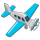

In [5]:
# Parameters

CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

# Load target image
target_img = load_emoji(TARGET_EMOJI)
imshow(target_img)

In [6]:
# Define PyTorch Model

class CAModel(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    conv1 = nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )

  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier) in TF
      but should be (out_channels, in_channels / groups, H, W) in Torch"""
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    kernel = torch.repeat_interleave(stacked_filters, self.channel_n, dim=0).view(self.channel_n*3, 1, 3, 3)
    y = F.conv2d(x, kernel, padding='same', groups=self.channel_n)
    return y

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    # x = x.view(0, 3, 1, 2)
    pre_life_mask = get_living_mask(x)
    y = self.perceive(x, angle) 
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask
    
    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

CAModel().dmodel

Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

The seed input looks like this (note a tiny dot):


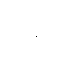

In [7]:
# Make training sample

p = TARGET_PADDING
target_img_tensor = torch.tensor(target_img)
pad_target = torch.nn.functional.pad(target_img_tensor, (0, 0, p, p, p, p))
h, w = pad_target.shape[:2]
seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
seed[h//2, w//2, 3:] = 1.0
print(f'The seed input looks like this (note a tiny dot):')
imshow(seed[..., :4])

In [8]:
# Training Sequence

class Train:
  def __init__(self, ca_model, target, lr=2e-3):
    self.ca = ca_model
    self.target = einops.repeat(target, '... -> b ...', b=BATCH_SIZE)
    self.lr = lr
    self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr, weight_decay=1e-8)
    self.loss_f = nn.MSELoss()

    # Log the training progress
    self.loss_log = []

  def train(self, x0, n_steps=1001):
    "Just support Growing mode for now"

    for i in range(n_steps+1):

      # Run through a single training step of the model
      x, loss = self._train_step(x0)
      self.loss_log.append(loss)

      # Printing
      if i % 100 == 0:
        clear_output()
        visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)
        plot_loss(self.loss_log)

      print('\r step: %d, log10(loss): %.3f'%(i, np.log10(loss)), end='')

    return self.loss_log
    
  def _train_step(self, x):
    """Perform the update step some random number of times"""
    iter_n = np.random.randint(64, 97, dtype=np.int32)
    # Clear previous gradients accumulated on parameters
    self.optim.zero_grad()
    for _ in range(iter_n):
      # Forward pass of model
      x = self.ca(x)

    # Compute loss
    loss = self.loss_f(to_rgba(x), self.target)

    # Compute gradients
    loss.backward()
    
    # Update parameters
    self.optim.step()

    return x, loss.item()


batch (before/after):


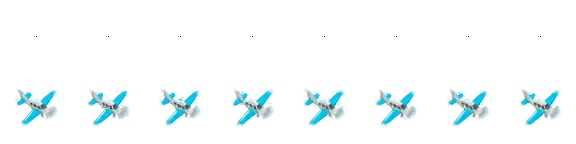

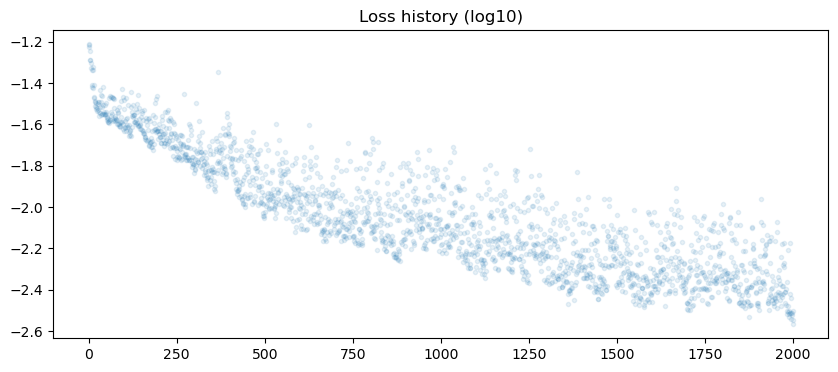

 step: 2001, log10(loss): -2.533CPU times: user 9min 25s, sys: 6.14 s, total: 9min 31s
Wall time: 14min 36s


In [11]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=2001)

In [17]:
# I have some pre-trained models saved in the 'models' folder

SAVE = True
if SAVE:
    save_ca_model(ca, "path_name")
else:
    ca_loaded = load_ca_model(CAModel, "vanilla_ca", device=device)

Saved model path_name to disk


100%|█████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 290.12it/s]

batch (before/after):


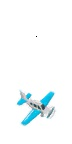

In [16]:
def simulate_model(model, init, n_steps, device=torch.device('cuda')):
    """Runs the simulation for ca model `models` for n_steps, starting
        from initial condition `init`.
    """
    with torch.no_grad():
        x, model = init.to(device), model.to(device)
        for _ in tqdm.trange(n_steps):
            x = model(x)
        visualize_batch(init.detach().cpu(), x.detach().cpu(), n_steps)
simulate_model(ca, seed.unsqueeze(0), 80, device=device)

<h2>Background</h2>
<p>The goal of this project is to make an equivariant version of either a 
two-dimensional or three-dimensional cellular automaton-like network, using 
ideas from the two main papers cited above. In the three-dimensional case 
this could obviously done with the e3nn library and standard concepts of 
equivariance in three-dimensional space covered in the class. 

If, however, a two-dimensional route is pursued, the equivariant model could potentially be implemented without such additional library. I am still unclear on how this would be done and would need to spend more time ideating this as well as discussing with others. </p>

<h2>Methods</h2> The models that would need to be built would be similar to the ones described in the above papers, with equivariance being additionally implemented. 

<p>Ideally, I wanted to do this in JAX, so below is a non-working re-implementation of the same PyTorch pipeline above. For some reason, I cannot run it on GPU with PyTorch imported, so there is an accompanying notebook dedicated just for the JAX version (which should at least run). The code from that notebook is reproduced here for ease of access however.</p>

In [9]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0)]

In [3]:
# Re-make the seed as JAX arrays

TARGET_SIZE = 40
CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.Resampling.LANCZOS)
  img = jnp.float32(img) / 255.0

  # premultiply RGB by Alpha
  img.at[..., :3].set(img[..., 3:])
  # img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  # code = hex(ord(emoji)).a.lower()
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)

target_img = load_emoji(TARGET_EMOJI)
imshow(target_img)

p = TARGET_PADDING
pad_target = jnp.pad(target_img, ((p, p), (p, p), (0, 0)))
h, w = pad_target.shape[:2]
seed = jnp.zeros((h, w, CHANNEL_N), jnp.float32)
seed = seed.at[h//2, w//2, 3:].set(1)
x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0) # batch it up
imshow(seed[..., :4])

2023-04-19 02:15:54.409634: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:429] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2023-04-19 02:15:54.410292: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:438] Possibly insufficient driver version: 520.61.5


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [ ]:
# https://github.com/deepmind/dm-haiku#quickstart

# Define JAX CA model. Not yet complete.

class CAModel(hk.Module):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE, name=None):
    super().__init__(name=name) # follow documented convention by passing in `name`
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.model = hk.Sequential([
        hk.Conv2D(output_channels=128, kernel_shape=1),
        jax.nn.relu,
        # Need initalize the below weights to zero
        hk.Conv2D(output_channels=CHANNEL_N, kernel_shape=1),
    ])

  def perceive(self, x,):
    identify = jnp.float32([0, 1, 0])
    identify = jnp.outer(identify, identify)
    dx = jnp.outer(jnp.float32([1, 2, 1]), \
                  jnp.float32([-1, 0, 1])) / 8.0  # Sobel filter
    dy = dx.T
    kernel = jnp.stack([identify, dx, dy], -1)[:, :, None, :]
    kernel = jnp.repeat(kernel, 16, axis=2)
    kernel_reshaped = kernel.reshape((3, 3, 1, 48))
    y = lax.conv_general_dilated(x0, kernel_reshaped, window_strides=(1, 1), padding="SAME",  feature_group_count=16,\
                                dimension_numbers=('NHWC', 'HWIO', 'NHWC'))
    return y

  def __call__(self, x):

    # Perceive neighbourhood
    y = self.perceive(x)

    # Pass through model
    dx = self.model(y)
    return x + dx


In [ ]:
# Training sequence. CURRENTLY NOT WORKING.

def loss_f(prediction, target):
  return jnp.mean(jnp.square(to_rgba(prediction) - target), axis=[-2, -3, -1]).mean()

def update(x, model, model_params, optimizer, optimizer_state):
  """This is where the actual learning happens"""
  grads = jax.grad(loss_f)(x, pad_target)
  print(f'grads is: {type(grads)}\
    and optimizer state is {type(optimizer_state)}')
  # print(f'grads: {grads}')
  updates, optimizer_state = optimizer.update(grads, optimizer_state, model_params)
  model_params = optax.apply_updates(model_params, updates)
  return model_params, optimizer_state, 

def train_step(x, model, model_params, \
               optimizer, optimizer_state):
  iter_n = np.random.randint(64, 97, dtype=np.int32)
  for _ in range(iter_n):
    x = model.apply(model_params, None, x)
  
  # Update model params
  model_params, optimizer_state = update(x, model, model_params, \
                                         optimizer, optimizer_state)
  
def train(x0, model, model_params, \
          optimizer, optimizer_state, n_train_steps=1000+1):
  
  for i in range(n_train_steps):
    x, loss = train_step(x0, model, model_params, \
                         optimizer, optimizer_state)

    if i % 100 == 0:
      clear_output()

      # visualize batch
      # plot loss
      # expot model (if desired)
    print('\r step: %d, log10(loss): %.3f'%(i, np.log10(loss)), end='')


In [ ]:
# THIS IS WHERE THE ERRORS OCCUR

def lift_model(x):
  model = CAModel()
  return model(x)

# Make an object with `init` and `apply` methods
ca_model = hk.transform(lift_model)

key = hk.PRNGSequence(22)
initial_params = ca_model.init(next(key), x0)
# print(type(params), params)
# y = ca_model.apply(initial_params, None, x0)

# Make optimizer
optimizer = optax.adam(learning_rate=2e-3)
optimizer_state = optimizer.init(initial_params)

train(x0, ca_model, initial_params, \
      optimizer, optimizer_state)

<h2>Experiments</h2> The experiments would relate closely to those in the paper, however, with the additional comparison of performance/ability for the model to grow a target shape in a different orientation from the one it was trained on. 

<h2>Conclusion</h2> The main take-aways from this project would be an implementation of an equivariant cellular automaton-like neural network that more fully captures the self-organizing process of biological organisms, which serve as a major inspiration for such models.